# Bead Model

This models what a bead should look like in OPT.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt

## Basic 1D Model

There are several ways we can model our beads
* Gaussian
* Top hat
* Sphere

Choose top hat for now.

In [2]:
def top_hat(x, width=7.5):
    # Top hat function, centred at 0
    hat = np.zeros(len(x))
    hat[np.abs(x)< width] = 1
    return hat

# Generate Gaussian profiles
def gaussian(x, sigma):
    return np.exp(-x**2/(2*sigma**2))

In [3]:
freqs = np.arange(-200, 200) # line pairs per mm

# Generate MTF profiles
profile = gaussian(freqs, 23)
profile_wide = gaussian(freqs, 80)

# FT to get PSFs
x = fftshift(fftfreq(len(freqs))) * 1000
psf_1 = fftshift(np.abs(fft(profile)))
psf_2 = fftshift(np.abs(fft(profile_wide)))

# define bead
bead = 100*top_hat(x)

# Take fourier transform of bead and perform convolutions in real space
bead_transform = np.abs(fftshift(fft(bead)))
multiplied = bead_transform * profile
multiplied_2 = bead_transform * profile_wide

convolved = fftshift(np.abs(ifft(multiplied)))
convolved_2 = fftshift(np.abs(ifft(multiplied_2)))

Plots of simulated MTFs, which I eyeballed from Srayan's MTF curves (in focus).

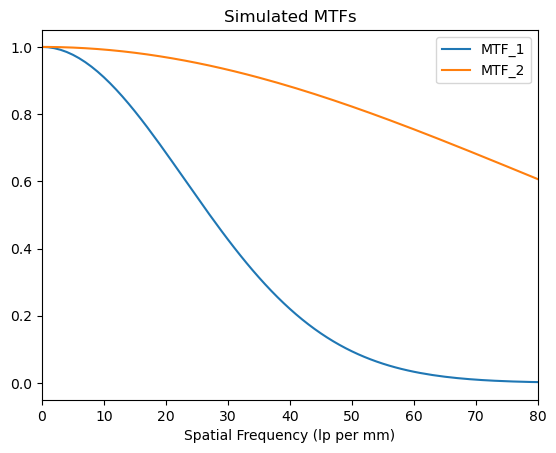

In [4]:
plt.plot(freqs, profile, label='MTF_1')
plt.plot(freqs, profile_wide, label='MTF_2')
plt.xlabel('Spatial Frequency (lp per mm)')
plt.title('Simulated MTFs')
plt.xlim(0, 80)
plt.legend()

Fourier transforming of the MTF to obtain the point spread function.

Also plot of the bead model (top hat) is shown.

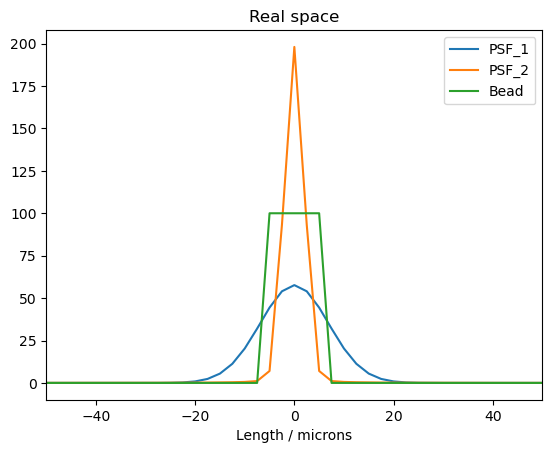

In [5]:
plt.title('Real space')

plt.plot(x, psf_1, label='PSF_1')
plt.plot(x, psf_2, label='PSF_2')
plt.plot(x, bead, label='Bead')
plt.xlabel('Length / microns')
plt.xlim(-50, 50)
plt.legend()

We want to convolve the bead with the PSF.

$$I = O * PSF$$

This is better done in Fourier Space

$$I = FT^{-1} (FT(O) \times FT(PSF)) $$
$$I = FT^{-1} (FT(O) \times MTF) $$

I first do a multiplication in frequency space of the FT of the bead (happens to be a sinc function) and then 

Text(0.5, 0, 'Spatial frequency')

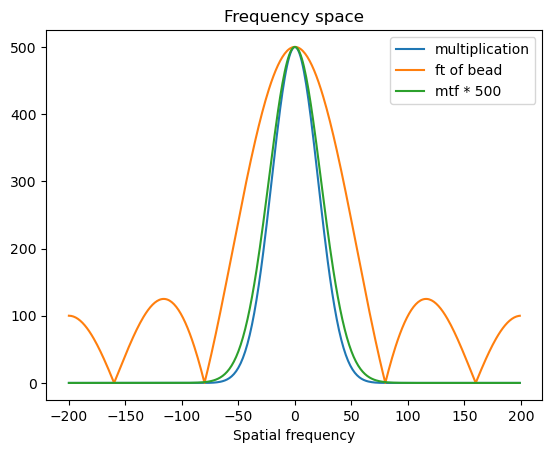

In [6]:
plt.title('Frequency space')
plt.plot(freqs, multiplied, label='multiplication')
plt.plot(freqs, bead_transform, label='ft of bead')
plt.plot(freqs, profile*500, label='mtf * 500')
plt.legend()
plt.xlabel('Spatial frequency')

(-50.0, 50.0)

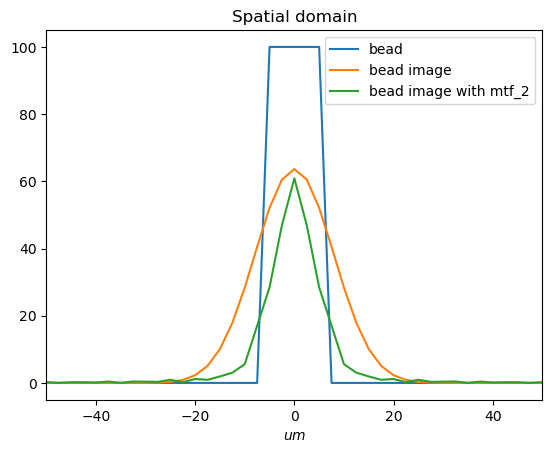

In [7]:
# plt.rcParams.update({'font.size': 14})
# plt.figure(figsize=(5,4))

plt.title('Spatial domain')

plt.plot(x, bead, label='bead')
plt.plot(x, convolved, label='bead image')
plt.plot(x, convolved_2/2, label='bead image with mtf_2')
plt.xlabel('$um$')
plt.legend()
plt.xlim(-50, 50)

## 2D Model

Kind of similar to what we were doing in `inverse.ipynb`.

Have 2D slice

For each angle
1. Convolve with 2D MTF
2. Take projection
3. Rotate slice
4. Repeat

In [8]:
N = 1040
N_theta = 180

slice = np.zeros((N, N))
slice[200:800] = np.sin(100*np.pi* np.arange(0, N)/N)

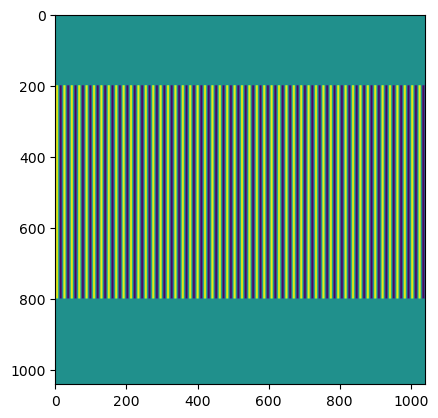

In [9]:
plt.imshow(slice)

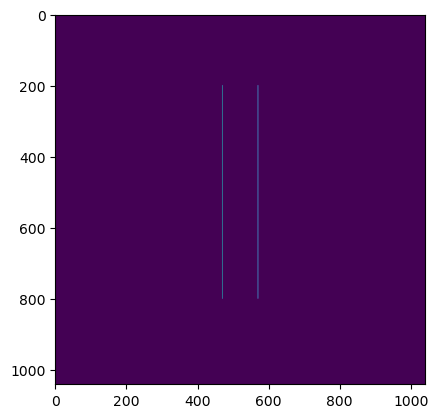

In [10]:
plt.imshow(np.abs(fftshift(fft(slice), 1)))

Generate 2D filter

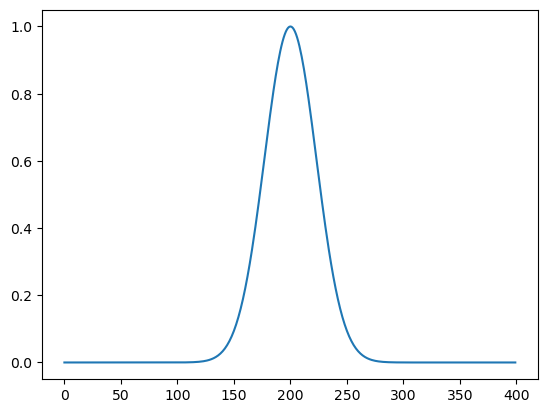

In [22]:
np.arange()

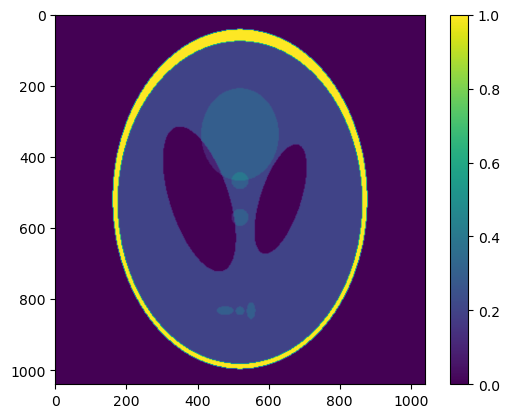

In [15]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon
from PIL import Image
phantom = shepp_logan_phantom()
phantom = rescale(phantom, scale=2.6, mode='reflect')
plt.imshow(phantom)
plt.colorbar()

In [16]:
image_width = len(phantom)
x = np.arange(0, image_width)

In [32]:
image_width

1040

Image width in mm is $w$.

Pixel size is $e$.

Frequency spacing is $\Delta k = 1/w$ line pairs per mm.

Nyquist frequency is $k_{\max} = 1/(2e)$, is your maximum spatial frequency.

Have $N_\text{pixels} = w/e$ and $k_{\max}/ {\Delta k} = N_\text{pixels} / 2$. 

Text(0.5, 0, 'Spatial frequency')

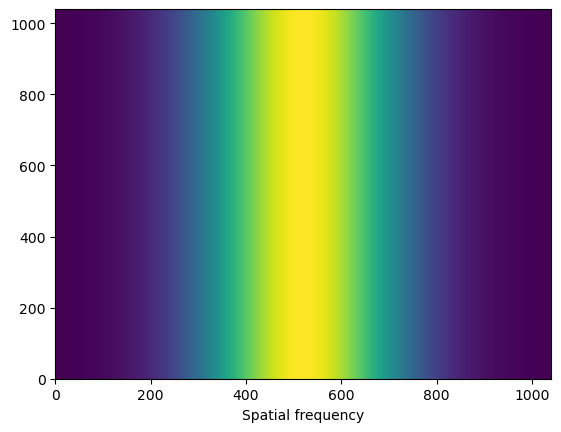

In [35]:
N_pixels = 1040
filter = np.zeros((N_pixels, N_pixels))
e = 6.45e-3 # Pixel size (mm)
nyquist_freq = 1/(2*e) # line pairs per mm
frequencies = np.linspace(-nyquist_freq, nyquist_freq, N_pixels)
for i in range(len(filter)):
    filter[i] = gaussian(frequencies, 23)

z = np.linspace(-N_pixels * e /2, +N_pixels * e /2, N_pixels)
plt.pcolormesh(filter)
plt.xlabel('Spatial frequency')

In [34]:
z

array([-3.354])

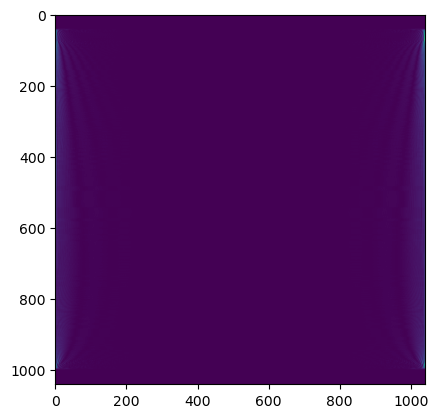

In [20]:
def forward_model(slice, MTF, num_angles):
    angles = np.linspace(0, 360, num_angles, endpoint=False)
    image_width = slice.shape[0] # number of pixels
    sinogram = np.zeros((num_angles, image_width))
    im_PIL = Image.fromarray(slice)
    
    for i in range(num_angles):
        # rotates anticlockwise
        theta = angles[i]
        rotated = np.array(im_PIL.rotate(theta, expand=False)) 
        # convolves each line in slice with PSF of that depth --> do in Fourier domain
        fourier_image = fft(rotated)
        plt.imshow(np.abs(fourier_image))
        filtered = ifft(fourier_image)

        # and then sums to get the projection
        # take line integral to get the projection
        projection = np.sum(filtered, axis=0)
        sinogram[i] = np.abs(projection)
        break
    return sinogram

simulated_sinogram = forward_model(phantom, None, 400).T

Backward model is just the Inverse Radon transform.

Though maybe we can derive convolution kernels for this.

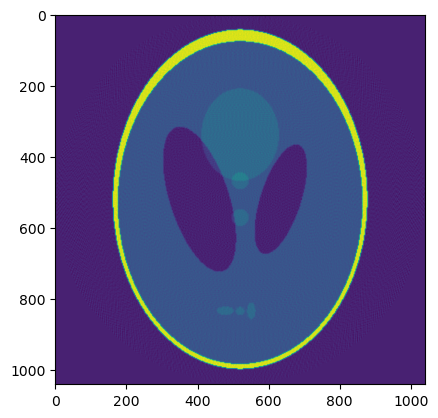

In [ ]:
plt.imshow(iradon(simulated_sinogram, -np.linspace(0, 360, 400, endpoint=False)))

Experimentation.

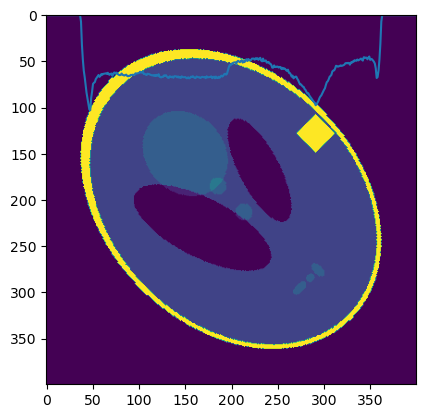

In [ ]:
phantom[200:230, 300:330] = 1
rotated = Image.fromarray(phantom).rotate(45.2, expand=False)
plt.imshow(np.array(rotated))

plt.plot(np.sum(rotated, axis=0))